In [1]:
!pip install xgboost

Libraries

In [4]:
import pandas as pd
import numpy as np
import sklearn.utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import KFold
import xgboost as xgb


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing CSV file from directory

In [5]:
from google.colab import files
uploaded = files.upload()

Saving AdSmartABdata.csv to AdSmartABdata.csv


In [6]:
#changing a file to dataset
import io
df2 = pd.read_csv(io.BytesIO(uploaded['AdSmartABdata.csv']))
df2.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,10/07/2020,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,07/07/2020,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,05/07/2020,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,03/07/2020,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,03/07/2020,15,Generic Smartphone,6,Chrome Mobile,0,0


In [7]:
#Taking our varibales of interest
raw_data = df2[['experiment','device_make','browser','yes']]
raw_data.head()

,experiment,device_make,browser,yes
0,exposed,Generic Smartphone,Chrome Mobile,0
1,exposed,Generic Smartphone,Chrome Mobile,0
2,exposed,E5823,Chrome Mobile WebView,0
3,control,Samsung SM-A705FN,Facebook,0
4,control,Generic Smartphone,Chrome Mobile,0


In [8]:
#data spliting into training 90%, 10% for test set
from sklearn.model_selection import train_test_split

x = raw_data.drop(['yes'], axis = 1)
y = raw_data[['yes']]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .1, random_state = 0)
print('xtrain shape:', x_train.shape)
print('xtest shape:', x_test.shape)
print('ytrain shape:', y_train.shape)
print('ytest shape:', y_test.shape)

xtrain shape: (7269, 3)
xtest shape: (808, 3)
ytrain shape: (7269, 1)
ytest shape: (808, 1)


In [9]:
#changing string columns to integers by using label encoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [10]:
xtrain_encoded = MultiColumnLabelEncoder(columns = ['experiment','device_make', 'browser']).fit_transform(x_train)

In [11]:
xtest_encoded = MultiColumnLabelEncoder(columns = ['experiment','device_make', 'browser']).fit_transform(x_test)

In [14]:
#function to calculate metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [15]:
#plotting model predictions
def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Observation')
    plt.ylabel('Choices')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

Training XG Boost model


In [16]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(xtrain_encoded,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
#model predictions
y_pred =model.predict(xtest_encoded)

Feature: 0, Score: 0.38525
Feature: 1, Score: 0.37007
Feature: 2, Score: 0.24468


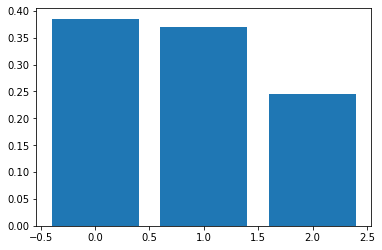

In [19]:
#getting and plotting model features 
import matplotlib.pyplot as plt
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show('Bar plot showing feature importance for XG boost most')
plt.show()

In [21]:
parameters = {
    'max_depth': 6,
    'objective': 'reg:linear',
    'booster': 'gblinear',
    'n_estimators': 1000,
    'learning_rate': 0.2,
    'gamma': 0.01,
    'random_state': 7,
}

In [22]:
#5-fold cross validation
from sklearn import model_selection
from sklearn.model_selection import KFold
kfold = model_selection.KFold(n_splits=5, random_state=0)
results_kfold = model_selection.cross_val_score(model, xtrain_encoded, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 92.82%


In [17]:

calculate_metrics(y_test, y_pred)

RMSE Score: 0.2745561201346213
R2_Squared: -0.2985114084940066
MAE Score: 0.22096573755993407


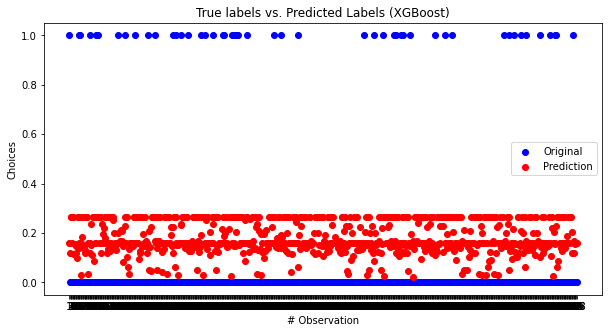

In [19]:
import matplotlib.pyplot as plt
plot_preds(y_test, y_preds, 'XGBoost')
